# Exercise 2 – Determining the spreading of epidemics

### Federico Agostini, Federico Bottaro, Gianmarco Pompeo 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

In [2]:
# create adjacency matrix for network A
index_i, index_j = np.loadtxt("net1.txt", dtype=np.int16, unpack=True)
dim = max(index_i.max(), index_j.max())+1
NetA_matrix = np.zeros((dim, dim))
for i,j in zip(index_i, index_j):
    # the adjacency matrix needs to be symmetric
    NetA_matrix[i, j] = 1
    NetA_matrix[j, i] = 1

In [3]:
# create adjacency matrix for network B
index_i, index_j = np.loadtxt("net2.txt", dtype=np.int16, unpack=True)
dim = max(index_i.max(), index_j.max())+1
NetB_matrix = np.zeros((dim, dim))
for i,j in zip(index_i, index_j):
    # the adjacency matrix needs to be symmetric
    NetB_matrix[i, j] = 1
    NetB_matrix[j, i] = 1

In [4]:
NetA = nx.from_numpy_array(NetA_matrix)
NetB = nx.from_numpy_array(NetB_matrix)

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


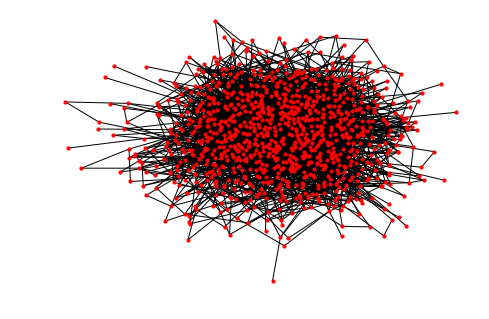

In [5]:
nx.draw(NetA, node_size=10)

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


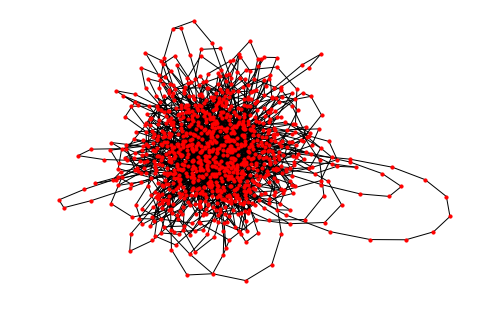

In [6]:
nx.draw(NetB, node_size=10)

## Task 1
Using the two networks provided in (A), calculate the epidemic threshold in the **SIS** dynamics for the homogenous, heterogenous and quenched mean-field approximations for $\mu=0.5$

In [20]:
# Preliminaries

mu = 0.5

## Average degree

### Network A
node_deg = NetA.degree()
node_deg = list(node_deg)
NetA_degree = np.array([x[1] for x in node_deg])
NetA_average_degree   = NetA_degree.mean() # <k_A>
NetA_average_degree_2 = np.mean(np.power(NetA_degree, 2)) # <(k_A)**2>
NetA_max_eigenvalue = np.max(np.real(np.linalg.eig(NetA_matrix)[0]))
print(NetA_max_eigenvalue)

### Network B
node_deg = NetB.degree()
node_deg = list(node_deg)
NetB_degree = np.array([x[1] for x in node_deg])
NetB_average_degree   = NetB_degree.mean() # <k_B>
NetB_average_degree_2 = np.mean(np.power(NetB_degree, 2)) # <(k_B)**2>
NetB_max_eigenvalue = np.max(np.real(np.linalg.eig(NetB_matrix)[0]))
print(NetB_max_eigenvalue)

6.284102805703304
7.530166187718354


In [21]:
# Homogeneus MF
NetA_lambda_MF = mu/NetA_average_degree
NetB_lambda_MF = mu/NetB_average_degree
print("HOMOGENEOUS MF")
print("Lambda_A =", NetA_lambda_MF)
print("Lambda_B =", NetB_lambda_MF)

HOMOGENEOUS MF
Lambda_A = 0.0971628449280995
Lambda_B = 0.13919821826280623


In [22]:
# Heterogeneous MF
NetA_lambda_HMF = mu*NetA_average_degree/NetA_average_degree_2
NetB_lambda_HMF = mu*NetB_average_degree/NetB_average_degree_2
print("HETEROGENEUOS MF")
print("Lambda_A =", NetA_lambda_HMF)
print("Lambda_B =", NetB_lambda_HMF)

HETEROGENEUOS MF
Lambda_A = 0.08160482080558198
Lambda_B = 0.07587663709336713


In [23]:
# Quenched MF
NetA_lambda_QMF = mu/NetA_max_eigenvalue
NetB_lambda_QMF = mu/NetB_max_eigenvalue
print("QUENCHED MF")
print("Lambda_A =", NetA_lambda_QMF)
print("Lambda_B =", NetB_lambda_QMF)

QUENCHED MF
Lambda_A = 0.07956585298798928
Lambda_B = 0.06639959697244084


## Task 2
Implement the (stochastic) SIS model in the two networks and simulate the entire phase diagram for $\mu=0.5$. Compare the three theoretical thresholds with the numerical results. 

*Suggestion: you need to simulate many (e.g. 100) simulations for each network and compare mean and std with the different analytical approximations.*